# CIFAR10 Colorization

In this Project, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

First we import needed libraries

In [25]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

First we Define a custom dataset class by extensing `torch.utils.data.Dataset`

please notice our dataset should output two things:
- black-and-white
- image and the RGB image

our class should just be a wrapper for CIFAR10 dataset

In [3]:
class BlackAndWhiteCIFAR10(Dataset):
  def __init__(self, root='./data', train=True, download=True, transform=None):
    self.cifarset = torchvision.datasets.CIFAR10(root=root, download=download, train=train, transform=transform)
    self.transform = transforms.Grayscale()

  def __len__(self):
    return len(self.cifarset)

  def __getitem__(self, index):
    img, _ = self.cifarset[index]
    return self.transform(img), img

## Transforms & Dataset & Dataloader

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
mean = (0.49139968, 0.48215827, 0.44653124)
std = (0.24703233, 0.24348505, 0.26158768)

transform_train = transforms.Compose([
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

In [6]:
initial_trainset = BlackAndWhiteCIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

100%|██████████| 170M/170M [00:05<00:00, 31.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [7]:
initial_testset = BlackAndWhiteCIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)

Files already downloaded and verified


In [10]:
train_size = int(0.8 * len(initial_trainset))
val_size = len(initial_trainset) - train_size
trainset, valset = random_split(initial_trainset, [train_size, val_size])

In [11]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)

## Dataset Visualization

We visualize our dataset (black-and-white image along with the RGB image) by sampling from trainset

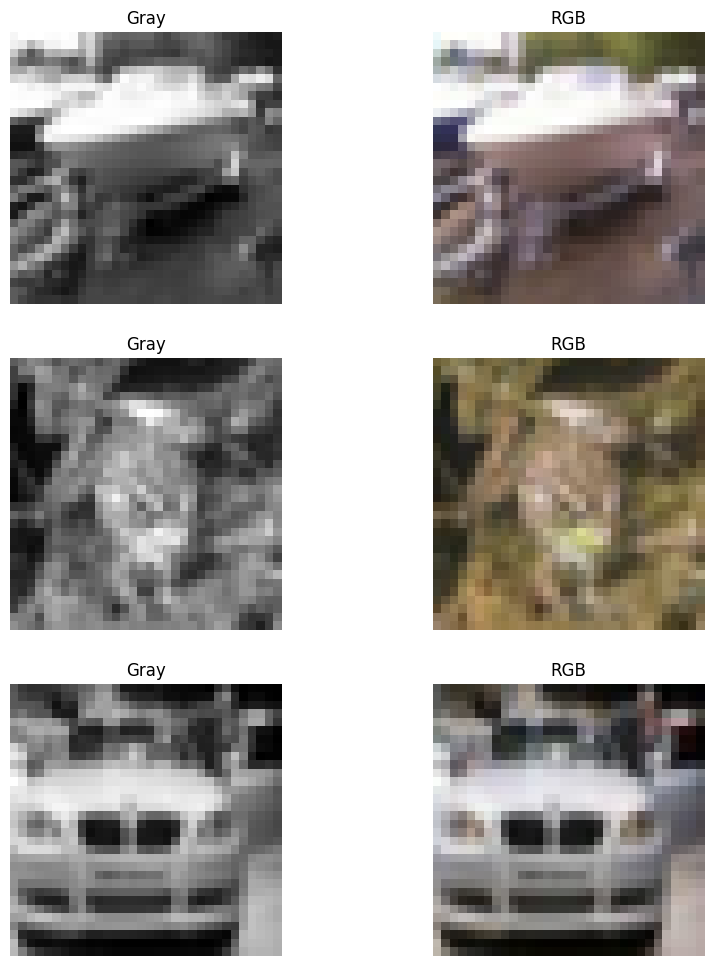

In [13]:
_, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(10, 12))

for i in range(3):
    bw, rgb = trainset[i]

    axs[i, 0].imshow(bw.numpy()[0], cmap='gray')
    axs[i, 0].set_title('Gray')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(rgb.numpy().transpose(1, 2, 0))
    axs[i, 1].set_title('RGB')
    axs[i, 1].axis('off')

plt.show()

## Model

 We define our model here (Input: black-and-white image, Output: RGB image)

For this task, we implement an autoencoder that does the colorization task. UNet could be a viable option

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, use_batchnorm=True):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=not use_batchnorm)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))

class TransConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        super(TransConvBlock, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=not use_batchnorm)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.batchnorm(self.transconv(x)))

class colorizationNet(nn.Module):
    def __init__(self):
        super(colorizationNet, self).__init__()
        self.enc1 = ConvBlock(1, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)

        self.dec1 = TransConvBlock(512, 256)
        self.dec2 = TransConvBlock(256, 128)
        self.dec3 = TransConvBlock(128, 64)
        self.final = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        dec1 = self.dec1(enc4)
        dec2 = self.dec2(dec1)
        dec3 = self.dec3(dec2)
        dec4 = self.final(dec3)
        return torch.sigmoid(dec4)

## Train

In this part we are going to train our model!
we track train loss and validation loss in each epoch to visualize the loss after training.


In [16]:
net = colorizationNet().to(device)
net

colorizationNet(
  (enc1): ConvBlock(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc2): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc3): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc4): ConvBlock(
    (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (d

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [18]:
import tqdm
from time import time

In [20]:
def train_epoch(net, criterion, optimizer, dataloader):
    net.train()
    running_loss = 0.0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Train Loss: {epoch_loss:.4f}')
    return epoch_loss


def eval_epoch(net, criterion, dataloader, test_mode=False):
    if test_mode:
        net.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'{"Test" if test_mode else "Validation"} Loss: {epoch_loss:.4f}')
    return epoch_loss


In [21]:
train_losses = []
val_losses = []

epochs = 35

for e in range(epochs):
    train_loss = train_epoch(net, criterion, optimizer, trainloader)
    val_loss = eval_epoch(net, criterion, valloader, test_mode=False)
    # scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {e + 1}")
    print("-" * 25)


Train Loss: 0.0126
Validation Loss: 0.0097
Epoch 1
-------------------------
Train Loss: 0.0093
Validation Loss: 0.0087
Epoch 2
-------------------------
Train Loss: 0.0085
Validation Loss: 0.0083
Epoch 3
-------------------------
Train Loss: 0.0082
Validation Loss: 0.0081
Epoch 4
-------------------------
Train Loss: 0.0079
Validation Loss: 0.0078
Epoch 5
-------------------------
Train Loss: 0.0076
Validation Loss: 0.0076
Epoch 6
-------------------------
Train Loss: 0.0075
Validation Loss: 0.0075
Epoch 7
-------------------------
Train Loss: 0.0073
Validation Loss: 0.0074
Epoch 8
-------------------------
Train Loss: 0.0072
Validation Loss: 0.0075
Epoch 9
-------------------------
Train Loss: 0.0071
Validation Loss: 0.0073
Epoch 10
-------------------------
Train Loss: 0.0069
Validation Loss: 0.0073
Epoch 11
-------------------------
Train Loss: 0.0068
Validation Loss: 0.0073
Epoch 12
-------------------------
Train Loss: 0.0067
Validation Loss: 0.0072
Epoch 13
---------------------

### Visualize Loss plot

Now we use the arrays that we have (from task 2 in the above section),and visualize the loss plot (train and validation together)

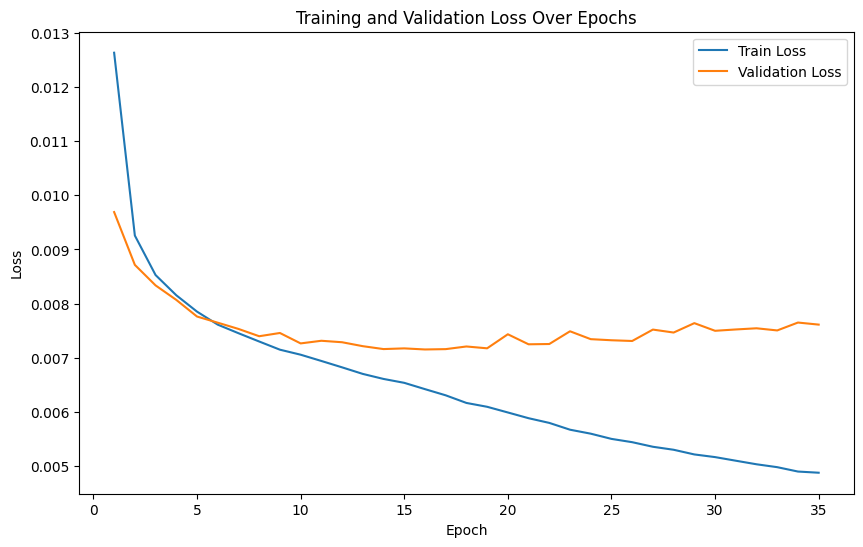

In [22]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

## Evaluation

1. First we sample 36 random samples from testset
2. than we give each of the 36 samples to our trained model and get the outputs
3. finaly we Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [23]:
def visualize_results(dataset, model, num_samples=36):
    indices = np.random.choice(range(len(dataset)), num_samples, replace=False)
    fig, axs = plt.subplots(num_samples, 3, figsize=(4, num_samples))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            bw_img, rgb_img = dataset[idx]
            bw_img = bw_img.unsqueeze(0).to(device)
            output = model(bw_img).cpu().squeeze(0)

            bw_img_denorm = bw_img.squeeze(0).cpu()
            rgb_img_denorm = rgb_img
            output_denorm = output

            axs[i, 0].imshow(bw_img_denorm.permute(1, 2, 0), cmap='gray')
            axs[i, 0].axis('off')
            if i == 0:
                axs[i, 0].set_title('Input\nBlack-and-White')

            axs[i, 1].imshow(output_denorm.permute(1, 2, 0).clamp(0, 1))
            axs[i, 1].axis('off')
            if i == 0:
                axs[i, 1].set_title('Output\nColorized')

            axs[i, 2].imshow(rgb_img_denorm.permute(1, 2, 0))
            axs[i, 2].axis('off')
            if i == 0:
                axs[i, 2].set_title('Ground Truth\nRGB Image')

    plt.tight_layout()
    plt.show()


## Final result

Files already downloaded and verified


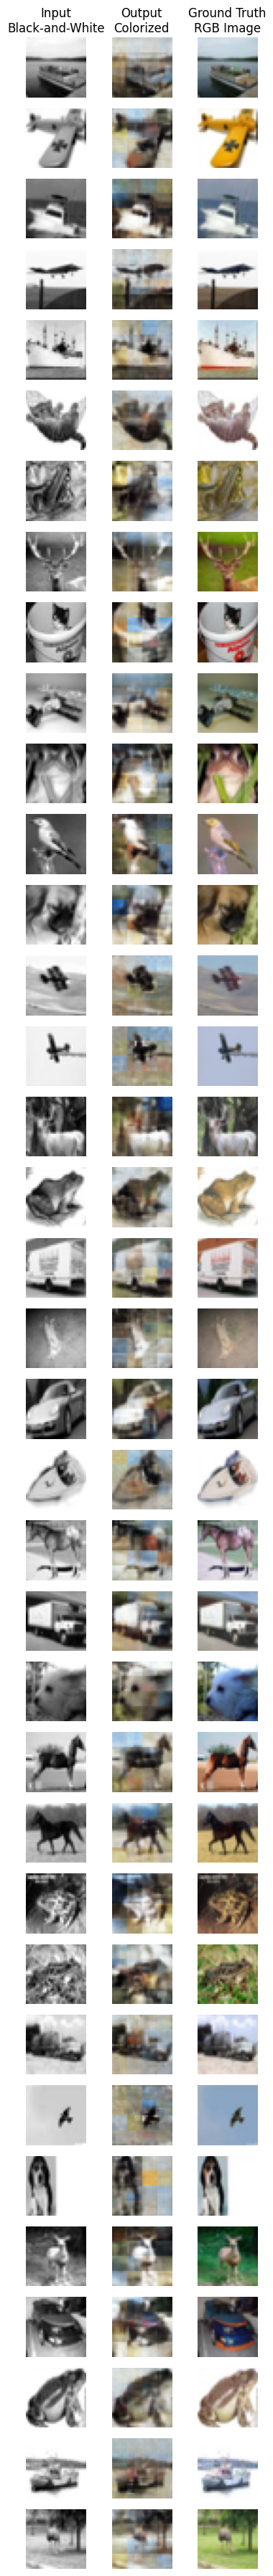

In [26]:
test_dataset = BlackAndWhiteCIFAR10(root='./data', train=False, download=True, transform=transform_test)
visualize_results(test_dataset, net, num_samples=36)